In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, math, json, random
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import kornia
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
from tqdm.autonotebook import tqdm
from pytorch_pretrained_biggan import BigGAN, convert_to_images, save_as_images
from src.notebook_utils import imshow, imgrid, pltshow, draw_tensors
from src.face_loss import DlibFaceLoss
from src.pytorch_utils import augment
from src.palette import random_biggan, load_directory, load_images
from src.collage import Collager
from src.collage_save import CollageSaver

In [3]:
img_size = 512

In [4]:
face_loss = DlibFaceLoss(filter_index=1)

# Mask generator

In [5]:
from src.gan import Generator
mask_generator = Generator(img_size=128, latent_size=100, channels=1).cuda()
# https://drive.google.com/file/d/1IhoB6lxbKxL66F0X99ntL-t3-XKnxDPZ/view?usp=sharing
model_path = './saved_models/dcgan_gen_128'
mask_generator.load_state_dict(torch.load(model_path))
mask_generator.eval()
None

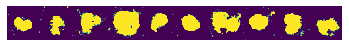

In [6]:
masks = mask_generator(torch.randn(10, 100).cuda())
pltshow(np.hstack(masks[:, 0].detach().cpu().numpy()))

# Make or load the palette

In [7]:
img_sets = [
    [ 
        './datasets/ab_biggan/2db513d411406270f1ee_hires.jpeg',
        './datasets/ab_biggan/2012fae76a825b03405d8f46_hires.jpeg'
    ],
    [
#         './datasets/ab_biggan/2db513d411406270f1ee_hires.jpeg',
        './datasets/ab_biggan/444d1f1c0ce6e5842c61_hires.jpeg',
        './datasets/ab_biggan/60009772d97f8a8fa0fe_hires.jpeg',
        
#         './datasets/ab_biggan/a81e9cae83db1804b094_hires.jpeg'
    ],
    [
        './datasets/sci-bio-art/7c78e087c6fd92a0e884_hires.jpeg',
        './datasets/sci-bio-art/285cf1ce669edeab9041_hires.jpeg',
    ]
]

In [8]:
USE_BIGGAN = False
if USE_BIGGAN:
    n_refs = 24*2
    biggan = BigGAN.from_pretrained(f'biggan-deep-{img_size}').cuda()
    palette = random_biggan(n_refs, img_size, biggan, seed=1, truncation=.4)
else:
#     palette_imgs_large = torch.cat([
#        load_directory('./datasets/eyes_closed/', 1024),
#        load_directory('./datasets/artbreeder/', img_size)
#     ])
    img_names = img_sets[2]
    palette_imgs_large = load_images(img_names, 1024)
    palette_imgs = F.interpolate(palette_imgs_large, size=(img_size, img_size), mode='bilinear')

/home/joel/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [9]:
patch_per_img = 20 // palette_imgs.shape[0]

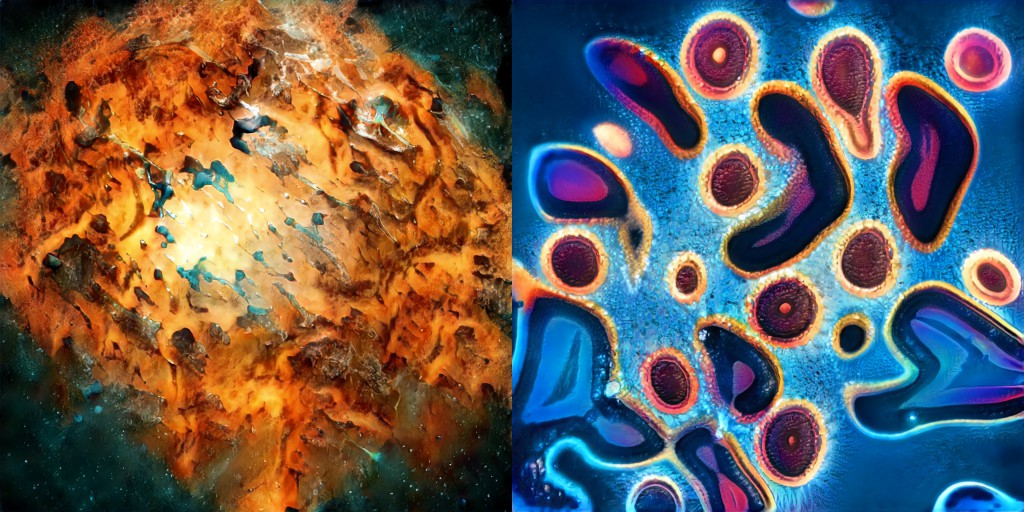

In [10]:
draw_tensors(palette_imgs)

In [11]:
collager = Collager(palette_imgs, mask_generator, img_size, patch_per_img)

# View Random

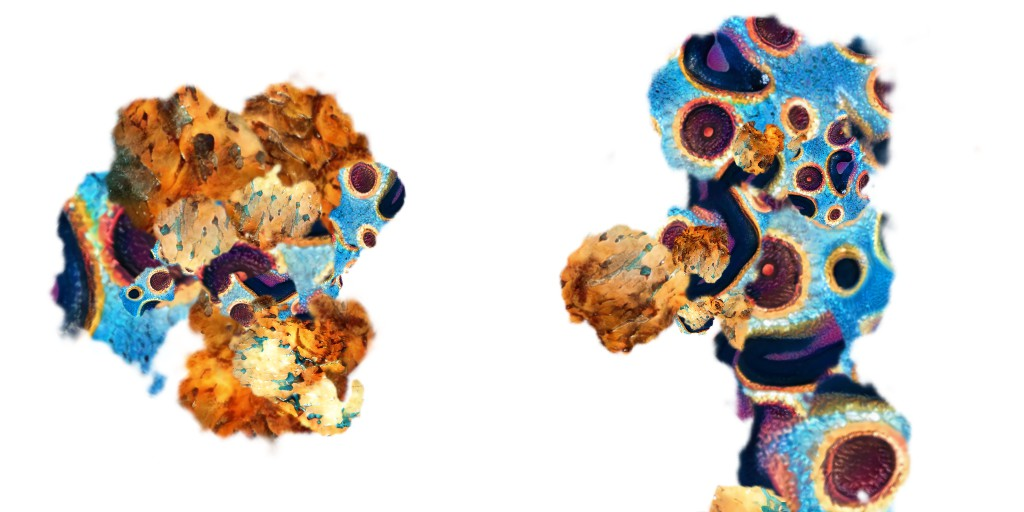

In [12]:
with torch.no_grad():
    imgs = [
        collager(*collager.makeRandom(seed=i, trans_scale=.2))[0]
        for i in range(2)
    ] 
    draw_tensors(torch.stack(imgs).squeeze())

# Optimization

/home/joel/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


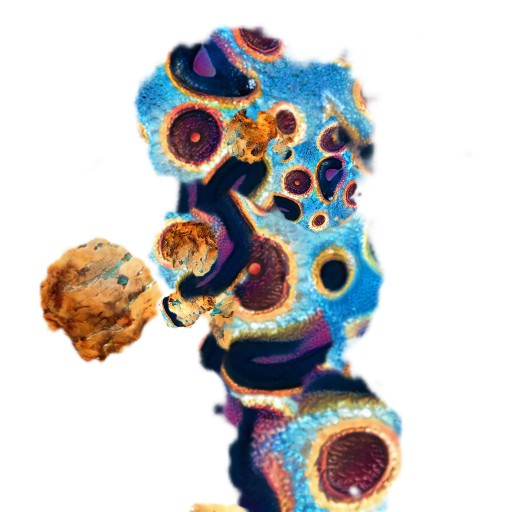

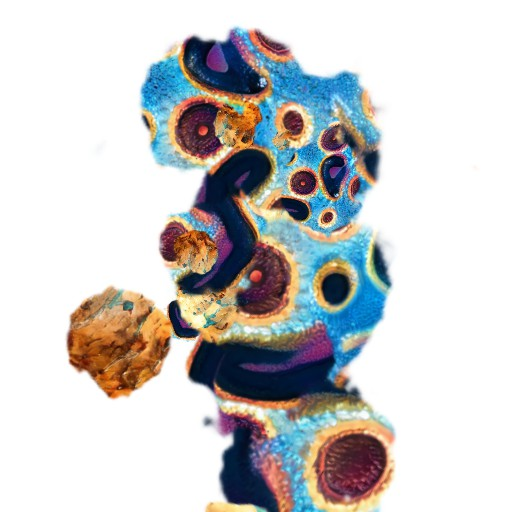

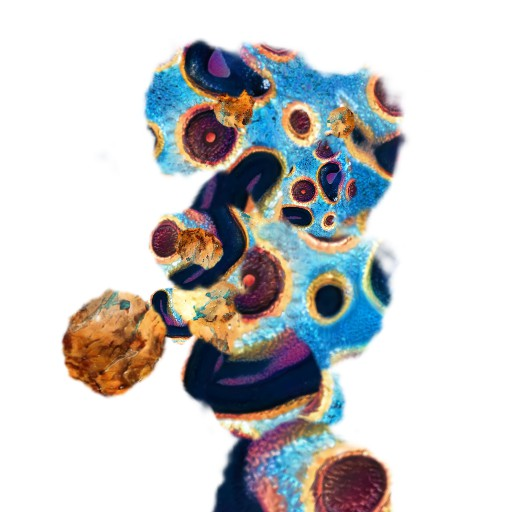

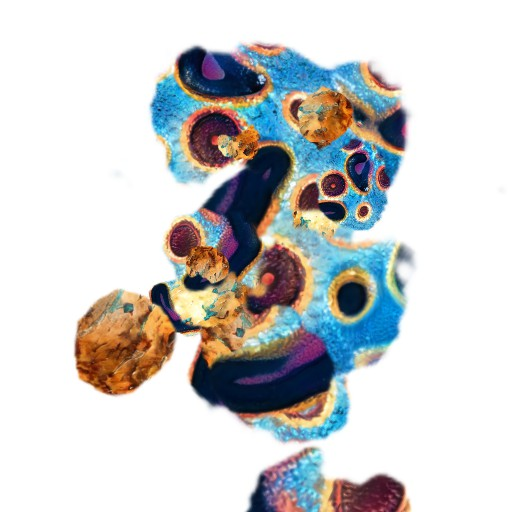

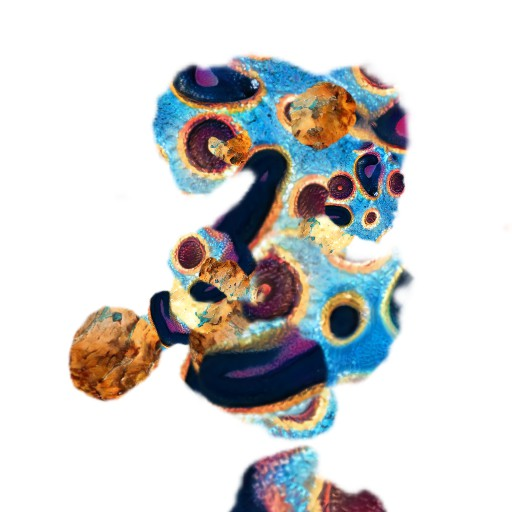

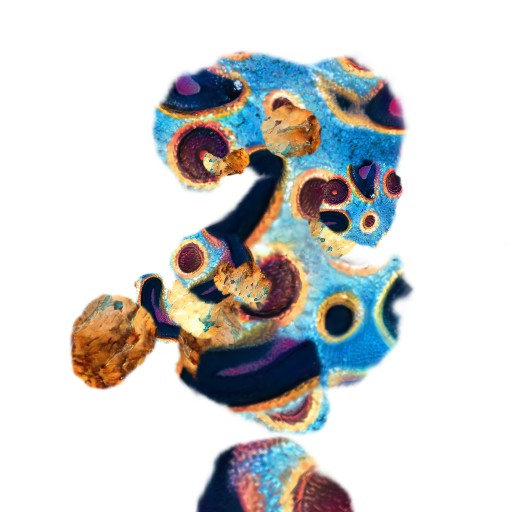

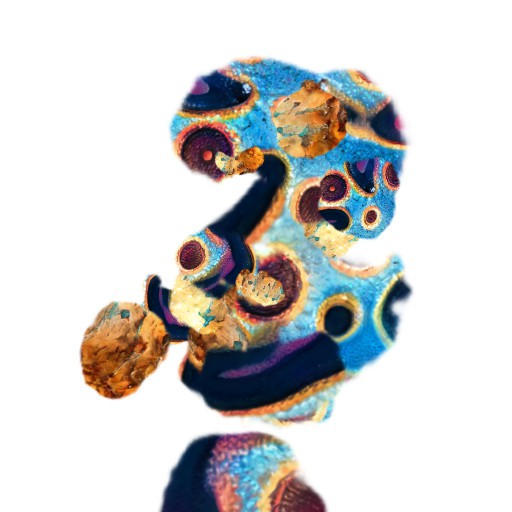

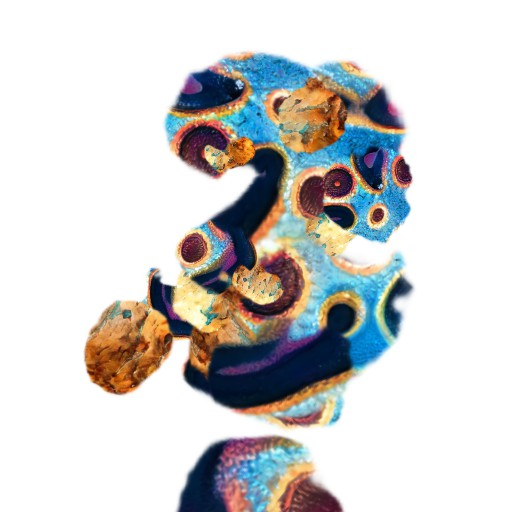

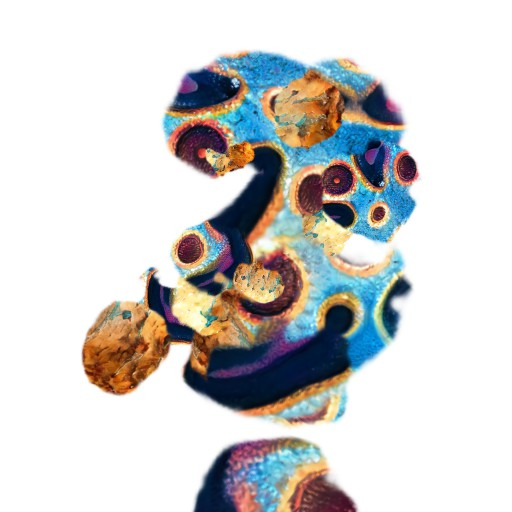

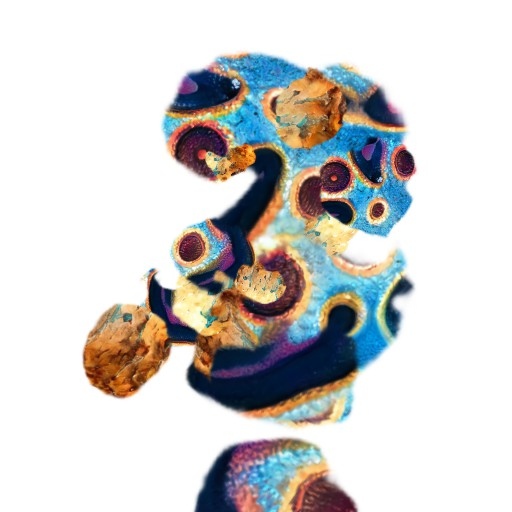

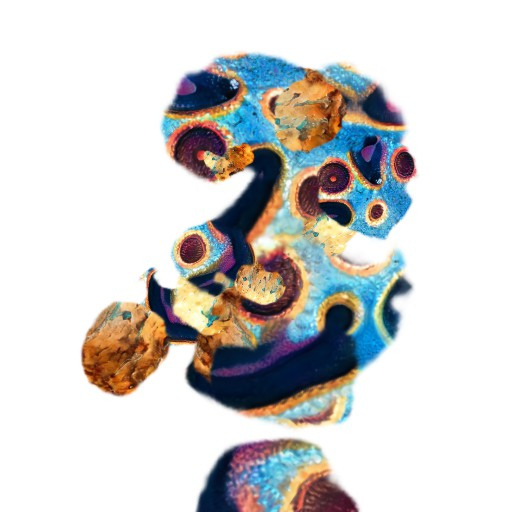

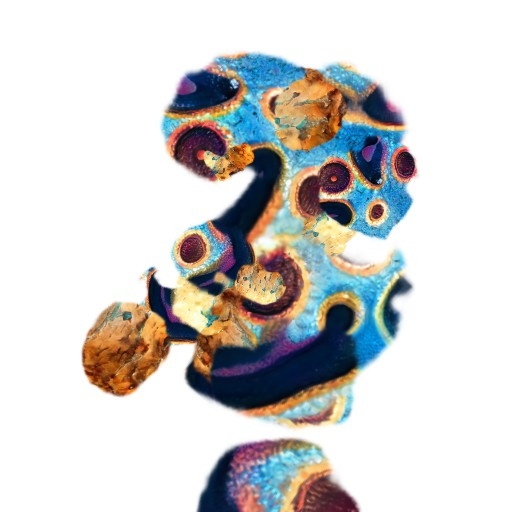

In [13]:
n_steps=600
seed=1
lr=1e-2
frames = []
#save_every_step = False
if seed is not None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
collage_data = collager.makeRandom(seed=seed, trans_scale=.2)
params = collage_data
Z = collage_data[0]
for x in collage_data:
    x.requires_grad_(True)
opt = torch.optim.Adam(params, lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, total_steps=n_steps)
pbar = tqdm(total=n_steps)
loss_history = []

for i in range(n_steps):
    percent = i / n_steps
    pbar.update()        
    opt.zero_grad()
    fl = torch.zeros(1)
    norm_loss = .25 * Z.norm()
    img, data = collager(*collage_data, return_data=False)
    aug = augment(img, n=3)
    fl = face_loss(((aug+1)*.5)).mean()
    loss = fl + norm_loss - .001*img.mean()
    loss_history.append(loss.detach().cpu().item())
    loss.backward(retain_graph=True)
    opt.step()
    scheduler.step()
    #if save_every_step:
    #    data = export_collager(*collage_data, return_data=True)
    #    saver.save(*data, final=True)
    pbar.set_description(f"fl: {fl.item():.3f}")
    frames.append(np.array(convert_to_images(img.detach().cpu())[0]))
    if i % 50 == 0 and i > 0 or i == n_steps-1:
        draw_tensors(img)

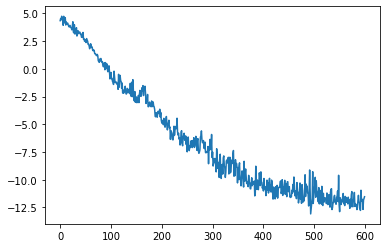

In [14]:
opt_img, opt_collage_data, opt_history = \
    img.detach(), tuple(x.detach() for x in collage_data), loss_history
_= plt.plot(opt_history)

# Export video, highres image and masks

In [15]:
saver = CollageSaver()
saver.save_palette(palette_imgs)
print(saver.path)
saver.save_video(frames)

# Regenerate at 2x scale.
export_collager = Collager(palette_imgs_large, mask_generator, 1024, patch_per_img)
with torch.no_grad():
    hires, data = export_collager(*collage_data, return_data=True) 
    saver.save(hires, data, final=True)

if img_names:
    with open(saver.path / 'image_names.txt', 'w') as outfile:
        json.dump(img_names, outfile)

/home/joel/anaconda3/envs/py36/lib/python3.6/site-packages/skvideo/__init__.py:306: UserWarning: ffmpeg/ffprobe not found in path: /usr/bin/ffmpeg
  warnings.warn("ffmpeg/ffprobe not found in path: " + str(path), UserWarning)


results/2020-10-10-20-19-oiydje
